# 12. 직접 만들어보는 OCR

## 1. 들어가며
이번 시간에는 OCR을 직접 만들어보는 시간을 갖도록 하겠다. OCR을 처음부터 끝까지 만들기에는 시간이 많이 소요되므로 Detection은 keras-ocr을 활용하고 Recognition을 직접 만들고 학습해보도록 하겠다.

### 실습목표
---
1. Text Recognition 모델을 직접 구현해본다.
2. Text Recognition 모델 학습을 진행해본다.
3. Text Detection 모델과 연결하여 전체 OCR 시스템을 구현한다.

### 목차
---
1. Overall sturcture of OCR
2. Dataset for OCR
3. Recognition model
    - Input Image
    - Encode
    - Build CRNN model
    - Train & Inference
4. 프로젝트 : End-to-End OCR

## 2. Overall structure of OCR

<img src="./image/ocr.png" />

<center><b>[https://brunch.co.kr/@kakao-it/318]</b></center>

우리가 만들고자 하는 OCR은 이미지 속에서 영문을 Bounding box로 찾아내고 그 Bounding box 내에 어떤 Text가 포함되는지 알 수 있는 시스템이다. 이미지 속에서 문자 영역을 찾아내는 것인 **Text Detection**은 강의노드에서 봤던 방법 중 Segmentation 기반의 **CRAFT**를 활용한 **keras-ocr**을 활용할 예정이다. **Recognition** 모델은 keras-ocr을 사용하지 않고 직접 만들어보도록 하겠다.

(참고자료)

- [keras-ocr 공식 github](https://github.com/faustomorales/keras-ocr)
- [CRAFT: Character-Region Awareness For Text detection](https://arxiv.org/pdf/1904.01941.pdf)
    - [CRAFT Pytorch 공식 implementation](https://github.com/clovaai/CRAFT-pytorch)
    - [CRAFT Keras 버전 github](https://github.com/notAI-tech/keras-craft)


__Q1. keras-ocr에서도 recognition을 지원하는데, 이 모델은 어떤 구조를 썼을까?__

* Convolution layer와 RNN을 결합하고 CTC로 학습된 CRNN이 사용되었다.

하지만 CNN과 RNN의 아이디어를 결합하여 Text Recognition의 초기 모델의 뼈대를 완성했던 CRNN 모델도 2015년에 나온 것이다. 그 이후로도 다양한 모델들이 새로운 기법을 제시하며 조금씩 성능향상을 이루어 왔다. 2019년에 발표된 Naver Clova의 아래 논문에서 당시까지의 모델의 발전사를 잘 살펴볼 수 있다.

- [What Is Wrong With Scene Text Recognition Model Comparisons? Dataset and Model Analysis](https://arxiv.org/pdf/1904.01906.pdf)

__Q2. keras-ocr의 CRNN 기반 Recognition 모델과 위 논문에 소개된 Recognition에서 가장 높은 성능을 얻은 (저자들의) 모델은 어떤 점이 다를까?__

* 첫번째로 입력이미지 변환 단계에서는 모델의 앞에서 글자를 Thin plate spline Transformation을 해주는 TPS 모듈이 붙고, 마지막 Text 출력 단계에서는 Bidirectional LSTM 뒤로 Attention decoder가 붙는다.

## 3. Dataset for OCR

OCR은 데이터셋에 필요한 텍스트 정보는 사람이 직접 입력을 해야하는 수고로움이 있다. OCR 데이터는 대량으로 만들어내려면 큰 비용이 든다. 이러한 데이터 문제를 해결하기 위한 방법 중 하나로는 컴퓨터로 대량이 문자 이미지 데이터를 만들어내는 방법이 있다. 직접 문자 데이터를 생성하게 되면 원하는 언어를 원하는 폰트 그리고 원하는 배치, 크기로 문자 이미지를 대량으로 만들어낼 수 있는 장점이 있다. 이전 스텝에서 소개했던 [What Is Wrong With Scene Text Recognition Model Comparisons? Dataset and Model Analysis](https://github.com/clovaai/deep-text-recognition-benchmark)과 같은 논문들에서는 Recognition model의 정량적인 평가를 위해서 **`MJ Synth`**와 **`SynthText`**라는 데이터셋을 활용한다. Recognition model을 제안하는 다양한 논문들에서도 성능 비교를 위해 두 데이터를 활용함을 기억해두면 좋을 것 같다.

1) [MJ Synth](http://www.robots.ox.ac.uk/~vgg/data/text/)

2) [SynthText](http://www.robots.ox.ac.uk/~vgg/data/scenetext/)

앞으로 만들어볼 Recognition model을 학습하기 위해 MJ Synth를 사용해보도록 하겠다. 아래의 링크는 Naver Clova의 논문 저자들이 Dropbox를 통해 제공하는 데이터셋이다. path 설정 후 아래 링크의 training 폴더에서 **`data_lmdb_release.zip`** 파일을 다운로드 받자! 오늘 우리는 이 20GB가 넘는 압축파일에 포함된 데이터 중에서 **`MJ`** 데이터만 활용할 예정이다.

[Dropbox-data_lmdb_release](https://www.dropbox.com/sh/i39abvnefllx2si/AAAbAYRvxzRp3cIE5HzqUw3ra?dl=0)

아래와 같이 진행하면 좀더 수월하다.

```bash
$ mkdir -p ~/aiffel/ocr
$ cd ~/aiffel/ocr
$ wget https://www.dropbox.com/sh/i39abvnefllx2si/AABX4yjNn2iLeKZh1OAwJUffa/data_lmdb_release.zip
$ unzip data_lmdb_release.zip
$ mv data_lmdb_release/training/MJ .# data_lmdb_release/training/MJ 아래의 데이터만 ~/aiffel/ocr 아래로 가져옵니다.
# 이후 불필요한 data_lmdb_release.zip 및 data_lmdb_release 하위의 남은 데이터는 삭제하셔도 무방합니다.
```

In [1]:
import os

path = os.path.join(os.getenv('HOME'),'aiffel/ocr')
os.chdir(path)

print(path)

/home/aiffel-dj10/aiffel/ocr


## 4. Recognition model (1)

Text recognition 모델을 직접 만들어보도록 하겠다. Recognition 모델은 2015년에 발표된 아래 논문에서 처음 소개된 CRNN 구조를 활용해서 만들어보도록 하자.

- [An End-to-End Trainable Neural Network for Image-based SequenceRecognition and Its Application to Scene Text Recognition](https://arxiv.org/pdf/1507.05717.pdf)

<img src="./image/crnn.png" />

<center><b>[https://arxiv.org/pdf/1507.05717.pdf]</b></center>

CRNN의 구조는 위 그림에서 아래부터 올라가는 순서로 보면 된다. 입력이미지를 Convolution Layer를 통해 Feature를 추출하고 추출된 Feature를 얻어낸다. Recurrent Layer는 추출된 Feature의 전체적인 Context를 파악하고 다양한 output의 크기에 대응이 가능하다. 끝으로 Transcription layer(Fully connected layer)는 step마다 어떤 character의 확률이 높은지 예측한다. 아래의 표를 통해 정확한 구조를 확인하자.

<img src="./image/crnn_structure.png" />

<center><b>[https://arxiv.org/pdf/1507.05717.pdf]</b></center>

몇 개의 Class가 필요한지 확인하기 위해 아래 코드를 실행하자.

In [2]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


__Q3. 영문 대문자와 숫자를 인식하기 위해서는 몇가지의 Class가 필요할까?__

* 총 36가지가 필요하다.
* 문자가 없는 경우를 위해서 공백을 추가할 경우 class의 수는 37개가 된다.

먼저 lmdb를 설치한다. LMDB는 Symas에서 만든 Lightning Memory-Mapped Database의 약자이다. 오늘 다루게 될 데이터셋이 lmdb 포맷(mdb)의 파일로 이루어져 있다.

```bash
$ pip install lmdb

```

아래에 필요한 라이브러리들을 import하도록 하자. 다운로드한 MJ 데이터셋의 위치도 확인해서 옮기자.

In [3]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

# 로컬 사용자
TRAIN_DATA_PATH = HOME_DIR+'/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/MJ/MJ_test'

# 클라우드 사용자는 아래 주석을 사용해 주세요.
# TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
# VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
# TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'
print(TRAIN_DATA_PATH)

/home/aiffel-dj10/aiffel/ocr/MJ/MJ_train


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## 5. Recognition model (2) Input Image
그럼 데이터셋 안에 들어있는 이미지가 실제로 어떻게 생겼는지 확인해보자. 아래는 lmdb를 통해 훈련데이터셋의 이미지를 4개만 열어서 실제 shape가 어떻게 생겼는지, 이미지나 라벨은 어떻게 달려 있는지를 확인해보자.

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


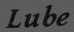

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


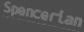

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


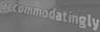

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


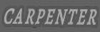

In [5]:
from IPython.display import display

env = lmdb.open(TRAIN_DATA_PATH, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
with env.begin(write=False) as txn:
    for index in range(1, 5):
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32 )
        
        print('target_img_size:{}'.format(target_img_size))
        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)
       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

어떤가? 대부분의 이미지의 height는 31, 최대 32까지로 되어 있고, width는 문자열 길이에 따라 다양한 것으로 보인다.

우리는 lmdb를 활용하여 케라스 모델 학습용 MJ Synth 데이터셋 클래스를 구현하려고 한다. dataset_path는 읽어들일 데이터셋의 경로이다. label_converter는 아래에서 여러분이 문자를 미리정의된 index로 변환해주는 converter로 직접 구현하도록 한다. 이외에도 batch_size와 입력이미지 크기 그리고 필터링을 위한 최대 글자 수, 학습대상으로 한정하기 위한 character등을 입력으로 받도록 구현되어 있다.

In [6]:
class MJDatasetSequence(Sequence):
    def __init__(self, 
                      dataset_path,
                      label_converter,
                      batch_size=1,
                      img_size=(100,32),
                      max_text_len=22,
                      is_train=False,
                      character=''
                ):
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            num_samples = int(txn.get('num-samples'.encode()))
            self.num_samples = int(num_samples)
            self.index_list = [index + 1 for index in range(self.num_samples)]
        
    def __len__(self):
        if self.is_train:
            return math.ceil(self.num_samples/self.batch_size/self.divide_length)
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 가져오는 메소드
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width,self.img_size[1] )
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            label = label.upper()[:self.max_text_len]
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)

        return (img, label)
    
    # idx번째 배치를 가져오는 메소드
    def __getitem__(self, idx):
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64')*self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            if len(encoded_label) > self.max_text_len:
                continue
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)

        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}
        return inputs, outputs
        
    def on_epoch_end(self):
        self.index_list =  [index + 1 for index in range(self.num_samples)]
        if self.is_train :
            np.random.shuffle(self.index_list)
            return self.index_list

위의 분석코드처럼 이미지 데이터를 img, label의 쌍으로 가져오는 부분은 `_get_img_label()` 메소드에 반영되었다. 그리고 `model.fit()`에서 호출되는 `__getitem__()` 메소드에서 배치 단위만큼 `_get_img_label()` 를 통해 가져온 데이터셋을 리턴하게 될 것이다. `_get_img_label()` 를 보면 다양한 사이즈의 이미지를 모두 height는 32로 맞추고, width는 최대 100까지로 맞추게끔 가공하고 있다.

## 6. Recognition model (3) Encode

이전 스텝에서 살펴본 바에 의하면, Label이 우리가 읽을 수 있는 평문 Text로 이루어져 있다. 이것은 모델을 학습하기 위해서 적절한 형태가 아니다. 따라서 각 Character를 class로 생각하고 이를 step에 따른 class index로 변환해서 encode를 해주어야 한다. 이를 해줄 수 있는 **`LabelConverter`** 클래스를 작성해보자.

- **`__init__()`** 에서는 입력으로 받은 text를 **`self.dict`**에 각 character들이 어떤 index에 매핑되는지 저장한다. 이 character와 index 정보를 통해 모델이 학습할 수 있는 output이 만들어진다. 만약 **`character='ABCD'`**라면 **`'A'`**의 label은 1, **`'B'`**의 label은 2가 된다.
- 공백(blank) 문자를 지정한다. 여기서는 공백 문자를 뜻하기 위해 **`'-'`**를 활용하며, label은 0으로 지정한다.
- **`decode()`**는 각 index를 다시 character로 변환한 후 이어주어 읽을 수 있는 text로 바꾸어준다.

> __*입력받은 text를 모델이 학습할 수 있는 label로 만드는 encode() 메소드를 구현하자. 단, 같은 글자가 연속으로 이어지는 경우에는 이어지는 그 사이에 공백 문자의 label을 포함해야 한다!*__

OCR 모델 학습데이터에 왜 공백 문자가 포함되어야 하는지는 다음 스텝에서 설명할 예정이다.

In [15]:
class LabelConverter(object):
     """ Convert between text-label and text-index """

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         for i, char in enumerate(text):
             if i > 0 and char == text[i - 1]:
                 encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
             encoded_label.append(self.label_map[char])
         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label

아래에서 'HELLO'를 Encode한 후 Decode가 정상적으로 되는지 확인해보도록 하자.

In [16]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


동일한 글자 __`'L'`__이 연속될 때, 그 사이에 공백 문자가 포함된 것을 확인할 수 있다.

## 7. Recognition model (4) Build CRNN model

이제 입력과 출력을 준비했으니 모델을 만들어볼 차례이다. Keras에서 제공하는 **`K.ctc_batch_cost()`**를 활용해서 loss를 계산하도록 **`ctc_lambda_func`**를 아래와 같이 만들어두었다.

In [17]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

여기서 잠시 Keras의 **`K.ctc_batch_cost()`** 함수에 대해 짚고 넘어가자. 비록 우리가 이 함수 내부를 직접 구현하진 않겠지만 CTC Loss 함수를 구현하기 위해 우리가 이 함수에 인자로 어떤 값을 넘겨야 하는지는 명확하게 파악해야 한다.

- 참고 : [Tensorflow Tutorial - ctc_batch_cost](https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras/backend/ctc_batch_cost)

<img src="./image/ctc.png" />

우리는 CTC Loss를 활용해야 하는 모델이 위 그림과 같은 상황을 다루기 위한 것임을 알고 있다. 입력의 길이 T와 라벨의 길이 U의 단위가 일치하지 않을 때, 그래서 라벨은 **`APPLE`**이지만 모델이 출력한 결과는 **`AAAPPPPLLLLEE`** 처럼 나올 수 있다. 이런 상황이 이미지에서 텍스트 라벨을 추론해야 하는 Text recognition 태스크에 동일하게 적용된다.

> _만약 모델이 **`AAAPPPPLLLLEE`**을 출력했다고 하자. 이때 추론 결과는 **`APLE`** 일지 **`APPLE`**일지 구분이 가능할까? 이 경우에는 **`APLE`**로 결론을 내리게 될 것이다. 그러므로 추론 결과가 **`APPLE`**이 되게 하려면 이미지의 라벨은 **`AP-PLE`**로 보정해 주어야 한다. 그래서 모델이 **`AAAPP-PPLLLEE`**로 출력을 한다면 추론 결과는 **`APPLE`**이 되는 것이다. 이런 이유로 이전 스텝에서 **`LabelConverter.encode()`** 메소드에 공백문자 처리로직을 포함했던 것이다._

위 텐서플로우 튜토리얼에 따르면, **`K.ctc_batch_cost(y_true, y_pred, input_length, label_length)`**에는 4가지 인자가 존재한다. 각각의 인자의 의미는 다음과 같다.

- **`y_true`**: tensor (samples, max_string_length) containing the truth labels.
- **`y_pred`**: tensor (samples, time_steps, num_categories) containing the prediction, or output of the softmax.
- **`input_length tensor`**: (samples, 1) containing the sequence length for each batch item in y_pred.
- **`label_length tensor`**: (samples, 1) containing the sequence length for each batch item in y_true.

(여기서 samples는 배치사이즈를 의미한다.)

<img src="./image/example.png" />

위 그림은 이전 스텝에서 살펴본 실제 데이터셋 예시이다. 이 케이스를 예로 들었을 때 위 인자들은 다음과 같이 될 것이다.

- **`y_true`**: 실제 라벨 **`LUBE`**. 그러나 텍스트 라벨 그대로가 아니라, 각 글자를 One-hot 인코딩한 형태로서, max_string_length 값은 모델에서 22로 지정할 예정
- **`y_pred`**: 우리가 만들 RCNN **`모델의 출력 결과`**. 그러나 길이는 4가 아니라 우리가 만들 RNN의 최종 출력 길이로서 24가 될 예정
- **`input_length tensor`**: 모델 입력 길이 T로서, 이 경우에는 텍스트의 width인 **`74`**
- **`label_length tensor`**: 라벨의 실제 정답 길이 U로서, 이 경우에는 **`4`**

---

이제, **`K.ctc_batch_cost()`**를 활용하여, **`image_input`**을 입력으로 그리고 마지막 Label을 'output'이라는 이름으로 출력하는 레이어를 갖도록 모델을 만드는 함수 **`build_crnn_model()`**을 구현해보자.

In [18]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')

    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    y_func = tf.keras.backend.function(image_input, [y_pred])
    return model, y_func

## 8. Recognition model (5) Train & Inference

이제 앞에서 정의한 **`MJDatasetSequence`**로 데이터를 적절히 분리하여 구성된 데이터셋을 통해 학습을 시켜보자. 우리는 시간이 많지 않으니 적절한 Epoch를 설정하여 모델을 학습시켜보자! 1Epoch에 10초 정도 소요될 것이다.

In [19]:
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'

model, y_func = build_crnn_model()
sgd = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'
)
model.fit(train_set,
        steps_per_epoch=len(val_set),
        epochs=100,
        validation_data=val_set,
        validation_steps=len(val_set),
        callbacks=[ckp])

Epoch 1/100
63/63 [==============================] - 34s 186ms/step - loss: 34.3142 - val_loss: 27.0527

Epoch 00001: val_loss improved from inf to 27.05271, saving model to /home/aiffel-dj10/aiffel/ocr/model_checkpoint.hdf5
Epoch 2/100
63/63 [==============================] - 10s 162ms/step - loss: 26.8003 - val_loss: 26.8556

Epoch 00002: val_loss improved from 27.05271 to 26.85558, saving model to /home/aiffel-dj10/aiffel/ocr/model_checkpoint.hdf5
Epoch 3/100
63/63 [==============================] - 10s 164ms/step - loss: 26.2296 - val_loss: 26.1449

Epoch 00003: val_loss improved from 26.85558 to 26.14486, saving model to /home/aiffel-dj10/aiffel/ocr/model_checkpoint.hdf5
Epoch 4/100
63/63 [==============================] - 11s 166ms/step - loss: 25.8257 - val_loss: 26.5932

Epoch 00004: val_loss did not improve from 26.14486
Epoch 5/100
63/63 [==============================] - 10s 165ms/step - loss: 25.2634 - val_loss: 25.6903

Epoch 00005: val_loss improved from 26.14486 to 25.69

63/63 [==============================] - 9s 149ms/step - loss: 3.1048 - val_loss: 3.1593

Epoch 00085: val_loss did not improve from 3.09206
Epoch 86/100
63/63 [==============================] - 9s 144ms/step - loss: 3.1317 - val_loss: 3.0150

Epoch 00086: val_loss improved from 3.09206 to 3.01496, saving model to /home/aiffel-dj10/aiffel/ocr/model_checkpoint.hdf5
Epoch 87/100
63/63 [==============================] - 9s 144ms/step - loss: 2.8504 - val_loss: 3.2349

Epoch 00087: val_loss did not improve from 3.01496
Epoch 88/100
63/63 [==============================] - 9s 144ms/step - loss: 2.8039 - val_loss: 3.0285

Epoch 00088: val_loss did not improve from 3.01496
Epoch 89/100
63/63 [==============================] - 9s 149ms/step - loss: 2.7474 - val_loss: 2.9979

Epoch 00089: val_loss improved from 3.01496 to 2.99794, saving model to /home/aiffel-dj10/aiffel/ocr/model_checkpoint.hdf5
Epoch 90/100
63/63 [==============================] - 9s 144ms/step - loss: 2.7014 - val_loss: 2.99

이제 학습한 모델을 테스트셋에서 inference해보고 이를 눈으로 직접 확인해보자!

Result: 	 SLINKING9999999999999999


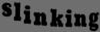

Result: 	 ALEPPO99999999999999999


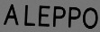

Result: 	 IWENDA999999999999999999


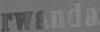

Result: 	 NATHANS99999999999999999


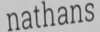

Result: 	 HALLO999999999999999999


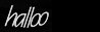

Result: 	 HURLS9999999999999999999


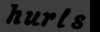

Result: 	 DOWNSIZE9999999999999999


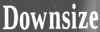

Result: 	 ROBOTIC99999999999999999


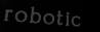

Result: 	 SLOPPY99999999999999999


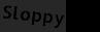

Result: 	 HERMITE99999999999999999


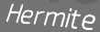

In [20]:
from IPython.display import display

test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

model, y_func = build_crnn_model()

model.load_weights(checkpoint_path)
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

def decode_predict_ctc(out, chars = TARGET_CHARACTERS, top_paths = 1):
    results = []
    beam_width = 5
    if beam_width < top_paths:
        beam_width = top_paths
    for i in range(top_paths):
        indexes = K.get_value(
            K.ctc_decode(
                out, input_length = np.ones(out.shape[0]) * out.shape[1],
                greedy =False , beam_width = beam_width, top_paths = top_paths
            )[0][i]
        )[0]
        text = ""
        for index in indexes:
            text += chars[index]
        results.append(text)
    return results

def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model_pred.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model, test_set, index=10)